Setups

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.util import img_as_float

Block Matching

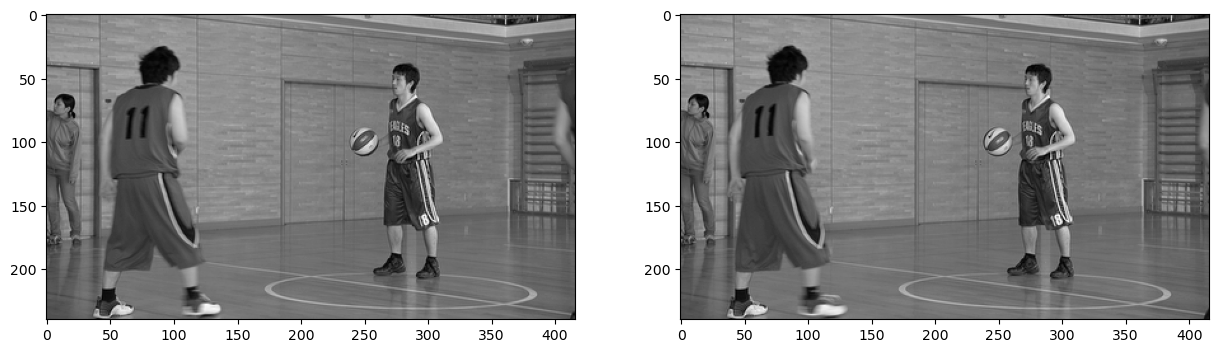

In [2]:
#load two frames as floating point format
frame1 = img_as_float(io.imread('data/resources/frame1.png'))
frame2 = img_as_float(io.imread('data/resources/frame2.png'))
#plot
fid, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(frame1, cmap='gray')
axs[1].imshow(frame2, cmap='gray')
plt.show()

Do the SSD (sum of squared diffference)

In [3]:
def compute_ssd(block_reference, block_moved):
    return np.sum(np.square(block_moved - block_reference))

Motion Search:
Proceed as follows*:
1. Calculate the block position in the reference frame from the **block index** and **block size**
2. Extract the pixel values for the reference block from the reference image
3. Loop through the vertical and horizontal shifts within the search range
    1. Calculate the shifted block position in the moved frame from the **block position in the reference frame**, the **padding of the moved frame**, and the current **vertical and horizontal shift**
    2. Extract the pixel values for the moved block from the moved image
    3. Calculate the SSD between the reference block and the moved block
    4. If the SSD is the best (minimum) of all SSD values so far, remember the current vertical and horizontal shift as the best motion vector
4. Return the best motion vector

In [4]:
def motion_search(block_index, image_reference, image_moved, block_size, search_range):
    block_pos = np.asarray(block_index) * block_size
    # index multiplied with size is the position of each block
    block_reference = image_reference[block_pos[0]:block_pos[0] + block_size,
                                      block_pos[1]:block_pos[1] + block_size]
    #get a block sized as block_size x block_size
    best_ssd = np.inf #infinity number
    #we looking for a ssd that smaller the better, initialize it as infinity then replaced by smaller number
    best_mv = np.array([np.nan, np.nan])
    # motion vector is still not found, set it as something unknown
    for mv_y in range(-search_range, search_range + 1):
        for mv_x in range(-search_range, search_range + 1):
            mv = np.array([mv_y, mv_x])
            block_pos_offset = block_pos + search_range + mv
            block_moved = image_moved[block_pos_offset[0]:block_pos_offset[0] + block_size,
                                      block_pos_offset[1]:block_pos_offset[1] + block_size]
            ssd = compute_ssd(block_reference, block_moved)
            if ssd < best_ssd:
                best_ssd = ssd
                best_mv = mv
    return best_mv

In [5]:
#Then the motion estimation
def motion_estimation(image_reference, image_moved, block_size, search_range):
    blocks_y = int(image_reference.shape[0] / block_size)
    blocks_x = int(image_reference.shape[1] / block_size)
    motion_vectors = np.empty((blocks_y, blocks_x, 2))
    image_moved_pad = np.pad(image_moved, search_range, mode='reflect')
    for i in range(blocks_y):
        for j in range(blocks_x):
            motion_vectors[i, j] = motion_search((i, j), image_reference, image_moved_pad, block_size, search_range)
    return motion_vectors

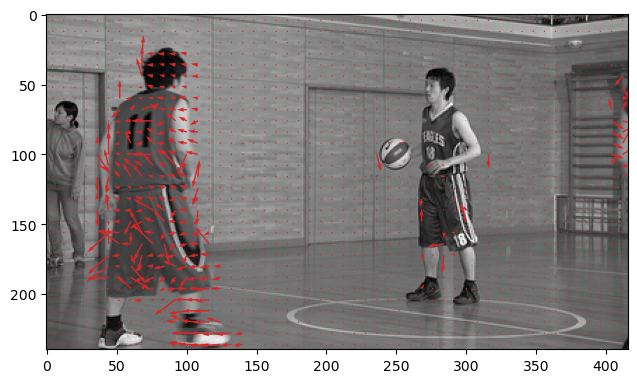

In [6]:
#run the estimation
block_size = 8
search_range = 16
motion_vectors = motion_estimation(frame1, frame2, block_size, search_range)

plt.figure(figsize=(7.5, 5))
plt.imshow(frame2, cmap='gray')
pos_y, pos_x = np.mgrid[:motion_vectors.shape[0], :motion_vectors.shape[1]] * block_size + block_size / 2
plt.quiver(pos_x, pos_y, motion_vectors[:, :, 1], motion_vectors[:, :, 0], angles='xy', scale_units='xy', scale=1, color='tab:red')#quiver draw the 2d arrows
plt.show()